In [1]:
from itertools import product, combinations
import math
import base64
import io
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch
from tensorboard.backend.event_processing import event_accumulator
from plotnine import *
import magicsoup as ms
from experiments.e1_co2_fixing.main import CHEMISTRY

theme_set(theme_minimal())
THIS_DIR = Path(".") / "experiments" / "e1_co2_fixing"

mol_2_idx = {d.name: i for i, d in enumerate(CHEMISTRY.molecules)}
CO2_IDX = mol_2_idx["CO2"]

In [2]:
def replicate(t: torch.Tensor, k=25.0) -> torch.Tensor:
    return t ** 3 / (t ** 3 + k ** 3)

def kill(t: torch.Tensor, k=0.005) -> torch.Tensor:
    return k / (t + k)

actions = {"replicated[X]": replicate, "killed[Acetyl-CoA]": kill}
n_mols = [1.0, 2.0, 3.0, 4.0, 5.0]
steps = list(range(1000))

records = []
for action, fun in actions.items():
    for n_mol in n_mols:
        for step in steps:
            records.append({
                "step": step,
                "n(X|Acetyl-CoA)": n_mol,
                "p(action)": (1 - (1 - fun(n_mol)) ** step),
                "action": action,
            })

df = pd.DataFrame.from_records(records)
df["action"] = pd.Categorical(df["action"], categories=[k for k in actions])

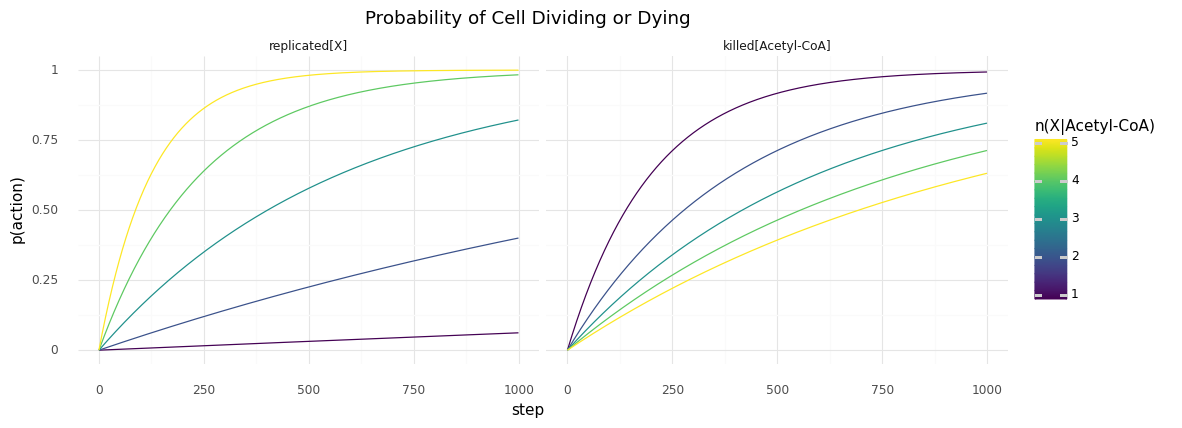

<ggplot: (8744796958838)>

In [3]:
(ggplot(df, aes(y="p(action)", x="step"))
    + geom_line(aes(color="n(X|Acetyl-CoA)", group="n(X|Acetyl-CoA)"))
    + facet_grid(". ~ action")
    + theme(figure_size=(12, 4))
    + ggtitle("Probability of Cell Dividing or Dying"))

In [4]:
runs = {
    "2023-01-13_10-39": "replication(k=10),kill(k=0.01)",
    "2023-01-13_11-34": "replication(k=50),kill(k=0.001)",
    "2023-01-13_12-40": "replication(k=15),kill(k=0.001)"
}
max_step = 10_000

tf_cell_scalars = ["Cells/Divisions[avg]", "Cells/Survival[avg]", "Cells/total[n]"]
records = []
for run_name, run_label in runs.items():
    run_dir = THIS_DIR / "runs" / run_name
    tf_event_file = next(run_dir.glob("*.out.tfevents.*"))
    tf_ea = event_accumulator.EventAccumulator(str(tf_event_file))
    tf_ea.Reload()    
    for tf_cell_scalar in tf_cell_scalars:
        for obj in tf_ea.Scalars(tf_cell_scalar):
            records.append({
                "run": run_label,
                "tag": tf_cell_scalar,
                "value": obj.value,
                "step": obj.step
            })
            if obj.step > max_step:
                break
df = pd.DataFrame.from_records(records)

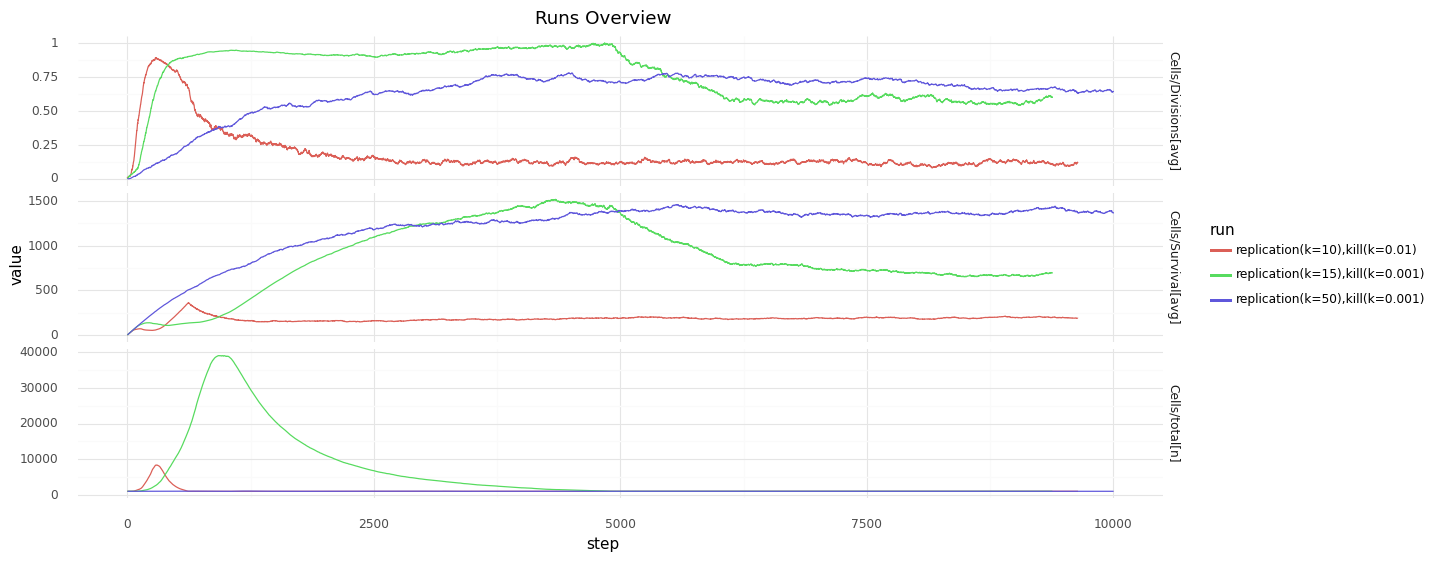

<ggplot: (8744796943469)>

In [5]:
(ggplot(df, aes(y="value", x="step"))
    + geom_line(aes(color="run"))
    + facet_grid("tag ~ .", scales="free_y")
    + theme(figure_size=(14, 6))
    + ggtitle("Runs Overview"))

In [6]:
run = "2023-01-13_12-40"
run_dir = THIS_DIR / "runs" / run
world = ms.World.from_file(rundir=run_dir)

max_idx = df.loc[(df["run"] == "replication(k=15),kill(k=0.001)") & (df["tag"] == "Cells/total[n]"), "value"].idxmax()
max_step = df.loc[max_idx, "step"]
df.loc[max_idx]

run      replication(k=15),kill(k=0.001)
tag                       Cells/total[n]
value                            39098.0
step                                 942
Name: 63779, dtype: object

In [7]:
step_range = (0, 2_500)
tf_ea = event_accumulator.EventAccumulator(str(tf_event_file), {"images": 200})
tf_ea.Reload()

cell_map_imgs = {}
for obj in tf_ea.Images("Maps/Cells"):
    if step_range[0] <= obj.step <= step_range[1]:
        cell_map_imgs[obj.step] = obj.encoded_image_string

44

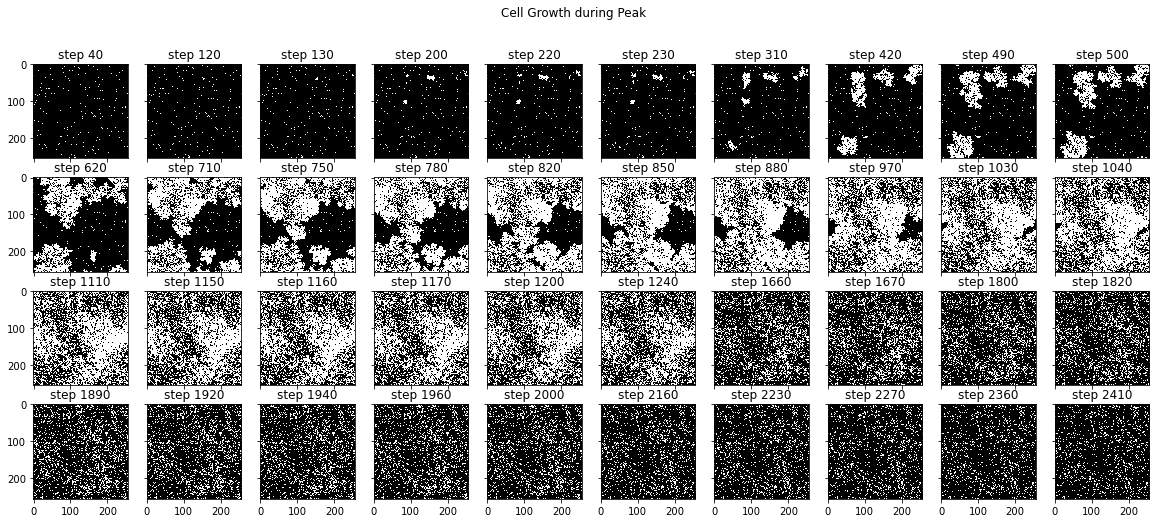

In [9]:
steps = sorted(list(cell_map_imgs))
n_cols = 10
n_rows = int(len(steps) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(20, 2 * n_rows))
for step, ax in zip(steps, axs.flatten()):
    bimg = io.BytesIO(cell_map_imgs[step])
    img = mpimg.imread(bimg, format='JPG')
    ax.imshow(img, interpolation='nearest')
    ax.title.set_text(f"step {step}")
fig.suptitle("Cell Growth during Peak")
plt.show()

In [102]:
max_idx = df.loc[(df["run"] == "replication(k=15),kill(k=0.001)") & (df["tag"] == "Cells/total[n]"), "value"].idxmax()
max_step = df.loc[max_idx, "step"]

all_saved_steps = sorted([int(d.name.split("step=")[1]) for d in run_dir.glob("step=*")])
_, idx = min((abs(d - max_step), i) for (i, d) in enumerate(all_saved_steps))
cell_max_saved_step = all_saved_steps[idx]
world.load_state(statedir=run_dir / f"step={cell_max_saved_step}")

In [63]:
all_saved_steps = sorted([int(d.name.split("step=")[1]) for d in run_dir.glob("step=*")])
_, idx = min((abs(d - cell_max_step), i) for (i, d) in enumerate(all_saved_steps))

cell_max_saved_step = all_saved_steps[idx]
world.load_state(statedir=run_dir / f"step={cell_max_saved_step}")
print(f"Loaded world at step {cell_max_saved_step} having {len(world.cells):,} cells")

Loaded world at step 2400 having 1,898 cells


In [75]:
all_saved_steps = sorted([int(d.name.split("step=")[1]) for d in run_dir.glob("step=*")])

mol_groups = {
    "ATP": ["ATP", "ADP"],
    "NADPH": ["NADPH", "NADP"],
    "FH4": ["FH4", "formyl-FH4", "methyl-FH4", "methylen-FH4"],
    "CoA": ["HS-CoA", "acetyl-CoA", "sucinyl-CoA"],
    "CO2": ["CO2", "formiat"],
    "NiACS": ["Ni-ACS", "methyl-Ni-ACS"]
}
mol_2_grp = {dd: k for k, d in mol_groups.items() for dd in d}

records = []
for saved_step in all_saved_steps:
    world.load_state(statedir=run_dir / f"step={saved_step}")
    n = world.map_size ** 2 + len(world.cells)
    for mol, idx in mol_2_idx.items():
        d = world.molecule_map[idx].sum() + world.cell_molecules[:, idx].sum()
        records.append({
            "name": f"{mol.name}[M]",
            "value": d.item() / n,
            "group": mol_2_grp.get(mol.name, "other"),
            "step": saved_step
        })
df = pd.DataFrame.from_records(records)

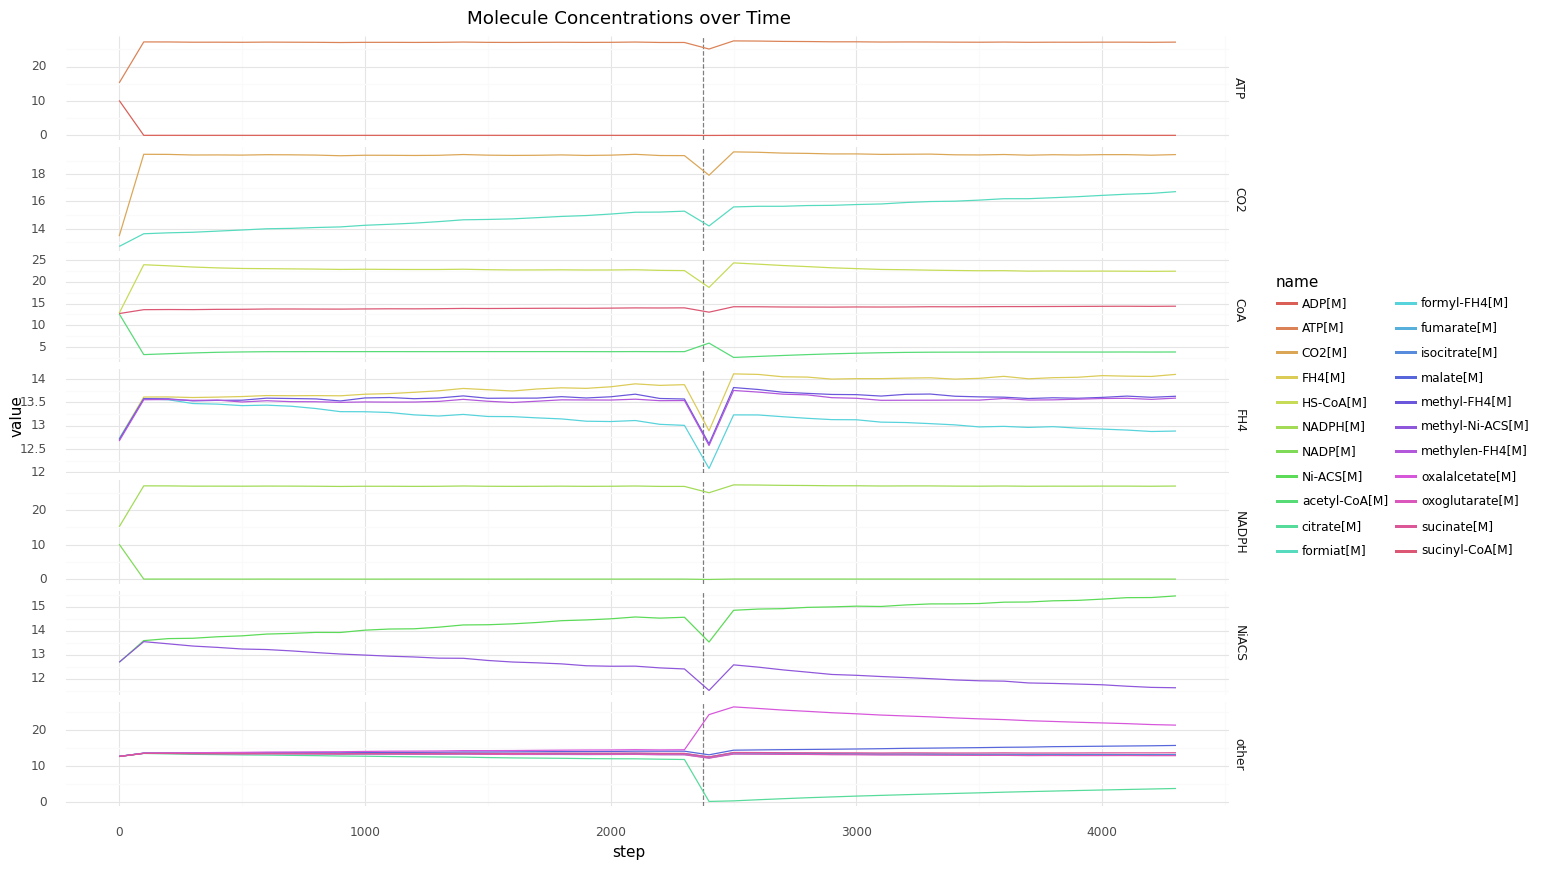

<ggplot: (8771396513786)>

In [78]:
(ggplot(df)
    + geom_vline(xintercept=cell_max_step, linetype="dashed", alpha=0.5)
    + geom_line(aes(y="value", x="step", color="name"))
    + facet_grid("group ~ .", scales="free_y")
    + theme(figure_size=(15, 10))
    + ggtitle("Molecule Concentrations over Time"))

In [83]:
def sign_sample(t: torch.Tensor, k=1.0, rev=False) -> list[float]:
    p = t ** 3 / (t ** 3 + k ** 3)
    if rev:
        p = 1.0 - p
    return p.tolist()

/home/marc/anaconda3/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


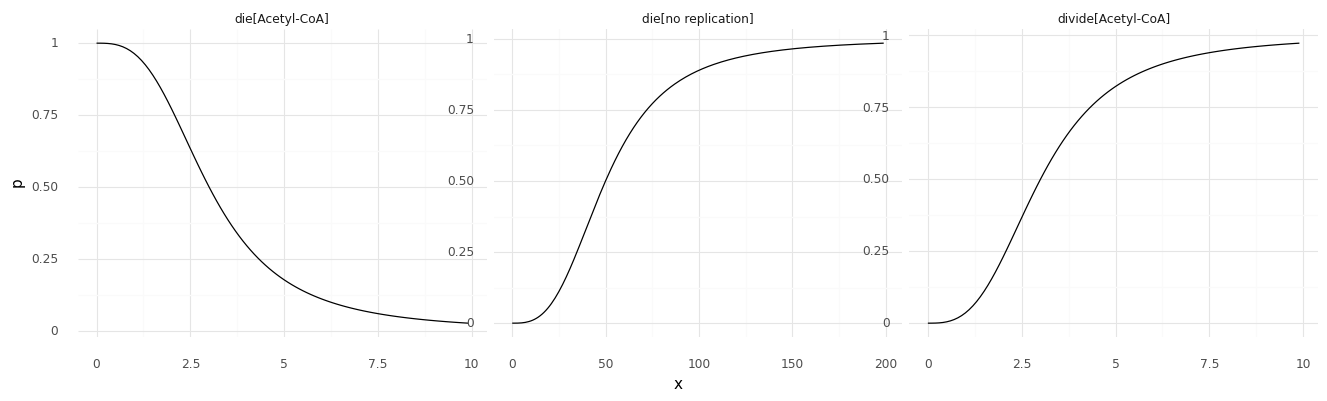

<ggplot: (8771395943536)>

In [96]:
x = torch.arange(0.0, 10.0, 0.1)
df1 = pd.DataFrame({"x": x.tolist(), "p": sign_sample(x, k=3.0)})
df1["label"] = "divide[Acetyl-CoA]"

df2 = pd.DataFrame({"x": x.tolist(), "p": sign_sample(x, k=3.0, rev=True)})
df2["label"] = "die[Acetyl-CoA]"

x = torch.arange(0.0, 200.0, 1.0)
df3 = pd.DataFrame({"x": x.tolist(), "p": sign_sample(t=x, k=50.0)})
df3["label"] = "die[no replication]"

(ggplot(pd.concat([df1, df2, df3]))
    + geom_line(aes(y="p", x="x"))
    + facet_wrap("label", scales="free")
    + theme(figure_size=(16, 4)))